In [1]:
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, t=None, cmap=None, ext=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        t : integer
            Timestep to plot.
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
        
        ext : string
            Extention of the color bar. Default is 'max'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        if not t:
            variable1 = data_set.mlotst
            variable2 = data_set.zo[0]
        else:
            variable1 = data_set.mlotst[t]
            variable2 = data_set.zo[t,0]
    else:
        if not t:
            variable1 = data_set
        else:
            variable1 = data_set[t]
        
    if not cmap:
        cmap = 'plasma_r'
        
    
    if ext:
        ext = ext
    else:
        ext = 'max'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable1, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend=ext)
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend=ext)  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, variable2, nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)

def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b)

def Normalize(data_set):
    mn = data_set.min(dim='week', skipna=True)
    mx = data_set.max(dim='week', skipna=True)
    
    y = (data_set - mn) / (mx - mn)
    return y


def Re_arrange(data_set, years):
    g = []

    for i,y in enumerate(years):
        aa = data_set.sel(time=data_set['year']==y)
        aa = aa.stack(map=('longitude', 'latitude'))
        aa = aa.groupby('time.week').mean(dim='time', skipna=True)
        
        aa = aa.reset_index(dims_or_levels='map')
        aa = aa.sel(week=slice(1,52))
        
        g.append(aa)
        del aa

    return(g)



def Shift(data_set):
    max_w = data_set.groupby('map').argmax(dim='week', keep_attrs=True, skipna=True).values
    r = 26 - max_w 
    
    data = data_set.T.values
    del data_set
    
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]
    r[r < 0] += data.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    shft = data[rows, column_indices]
    shift = xr.DataArray(shft.T, dims=['week', 'map'], name='mlotst')

    return(shift)

In [4]:
## This function isnot used
def Rolled(data_set):
    max_w = data_set.groupby('map').argmax(dim='week', keep_attrs=True, skipna=True).values
    h = 26-max_w
    #m = max_w <= 26
    #h = [ fun(element) if m[e]==True else gun(element) for e,element in enumerate(max_w) ]
    
    #rol = data_set.roll(h, roll_coords=True)
    rol = [np.roll(data_set[:,m], r, axis=0) for m,r in enumerate(h) ]
    return rol

In [5]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################
dir_1 = '../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_of = '/home/lgarcia/Documents/Other_datasets/'
dir_oi = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [6]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [7]:
coord = 'noa'
region = Crops(coord, c_armor1, reg_ext)
region2 = Crops(coord, c_armor15, reg_ext)

region2 = Masking(region2, region2.to[0,25])

In [8]:
points = region.mlotst[:,::4,::4].where(region2.mask==1)
print(points.latitude.size, points.longitude.size)

75 105


In [9]:
del c_armor1, c_armor15, region2, region, weeks, d1, d2

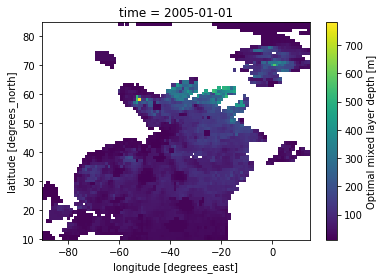

In [10]:
points[0].plot()

In [11]:
yr = points.time.dt.year
points.coords['year'] = (('time'), yr)

In [12]:
#del la, lo, valsla, valslo

## Re-shaping the dataset

It  is done in two groups. The analysis ignores the 2018 because is not complete and the 2010, because it causes problems with the dimensions. Why? I still do not know.

The shift is done to put the minimum at the first time step.

In [13]:
## Exclude 2018 because is not a full year
years1 = [y for y in range(2005, 2018)]

In [14]:
## Reshaping, normalizing and shifting
week1 = Re_arrange(points, years1)

In [15]:
## Big data arrays, with all the years and grid points
new_points = xr.concat(week1, dim='map')
new_points= new_points.dropna(dim='map', how='any')

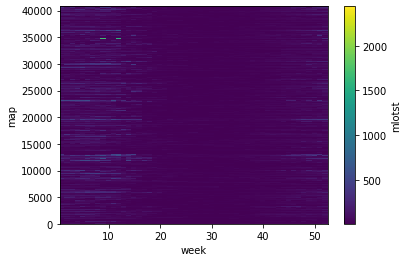

In [16]:
new_points.T.plot()

In [17]:
shifted = Shift(new_points)

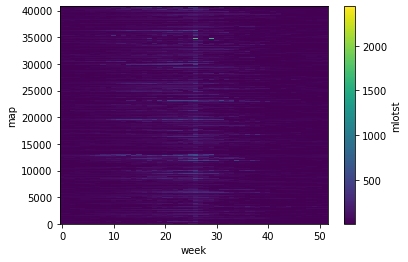

In [18]:
shifted.T.plot()

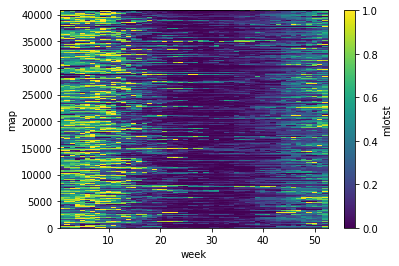

In [19]:
normalized_o = Normalize(new_points)
normalized_o = normalized_o.dropna(dim='map', how='any')
normalized_o.T.plot()

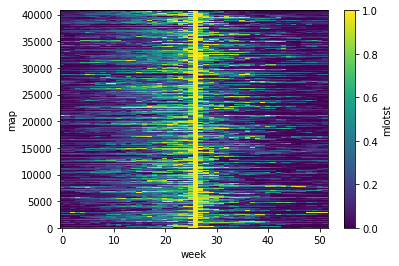

In [21]:
normalized_s = Normalize(shifted)
normalized_s = normalized_s.dropna(dim='map', how='any')
normalized_s.T.plot()

In [22]:
### So the datasets are:
## new_points :: Original data
## shifted :: Original data, shifted
## normalized_o :: Original data, normalized
## normalized_s :: Original data, normalized and shifted

## PCA for un-normalized-un-shifted dataset

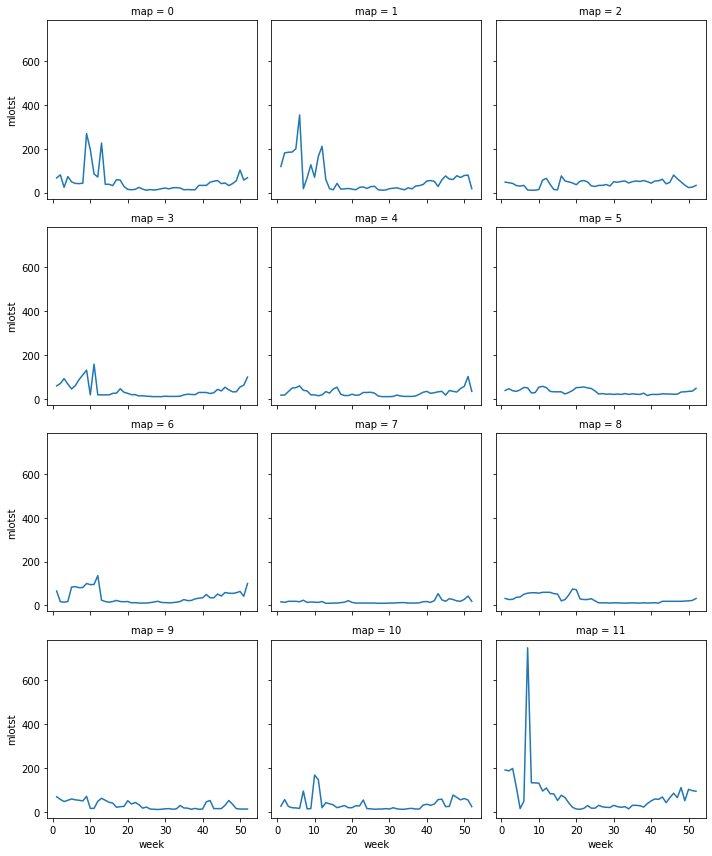

In [146]:
new_points[:,1200:1380:15].T.plot(col="map", col_wrap=3, hue='map')

In [23]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca_o = PCA(n_components=n_components)
pca_o.fit(new_points.T)

PCA(n_components=12)

In [24]:
print(pca_o.singular_values_)

[59063.44402292 21653.22192534 17869.38317861 15769.14938637
 14215.86212526 13221.0131777  12575.17106256 12412.29861841
 11741.92577994 11265.27117234 10793.05062208 10466.72891854]


In [26]:
## 53x12
reduced_values_o = pca_o.transform(new_points.T)

In [27]:
reduced_values_o.shape

(40801, 12)

In [28]:
## 53x12
print(pca_o.components_.size)

624


In [29]:
samp = reduced_values_o.shape[0]
eof = reduced_values_o.shape[1]
w = new_points.week.size

data = np.zeros((samp,eof,w))

result_o = xr.DataArray(data, dims=['sample', 'n_eof', 'week'], name="fake_data")

In [31]:
result_o['reduced_data'] = xr.DataArray(reduced_values_o, dims=['sample', 'n_eof'])

result_o['eigen_values'] = xr.DataArray(pca_o.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result_o['explained_variance'] = xr.DataArray(pca_o.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

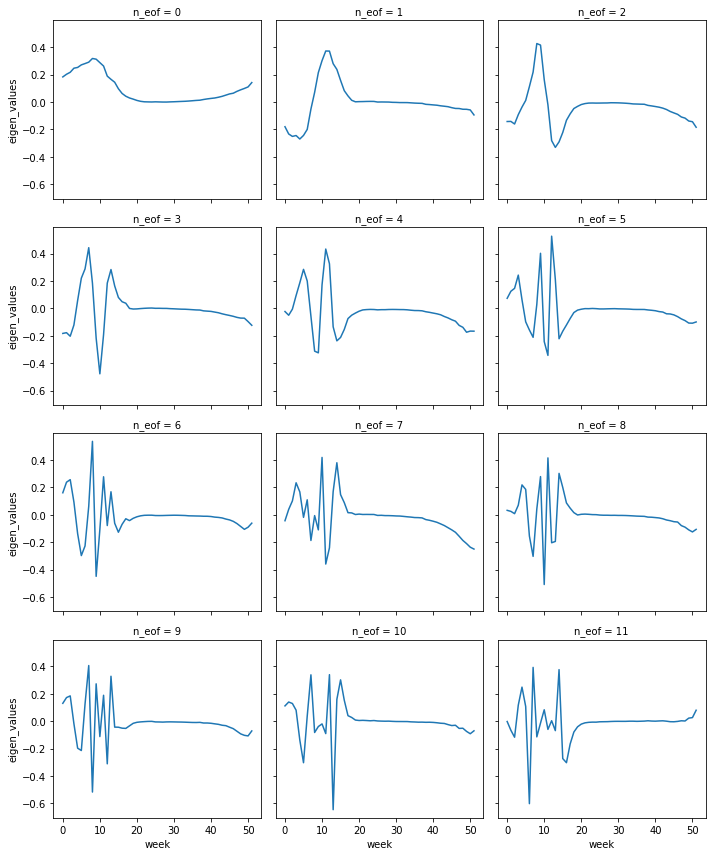

In [147]:
result_o['eigen_values'].plot(col="n_eof", col_wrap=3, hue='n_eof')
plt.show()

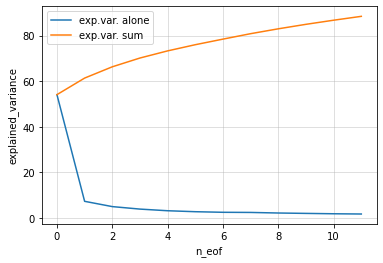

In [41]:
result_o['explained_variance'].plot(label='exp.var. alone')
result_o['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [125]:
PC = result_o['eigen_values'].dot(new_points.T, dims='week')

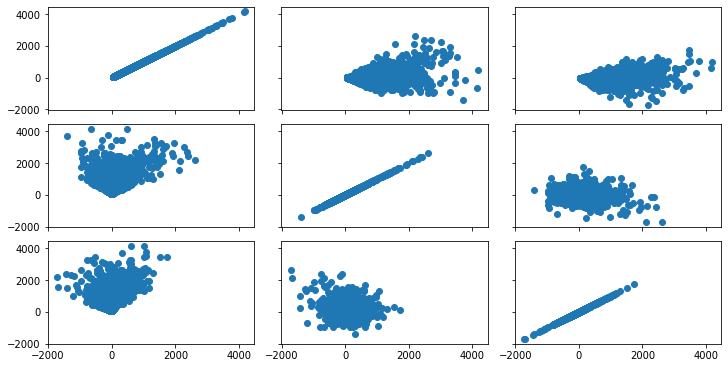

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5), 
                       sharex=True, sharey=True, constrained_layout=True)
for i in range(3):
    for j in range(3):
        x = PC[i]
        y = PC[j]
        name = 'PC' + str(i) + '-' + str(j)

        ax[i,j].scatter(x, y)

plt.show()

## PCA for un-normalized-shifted dataset

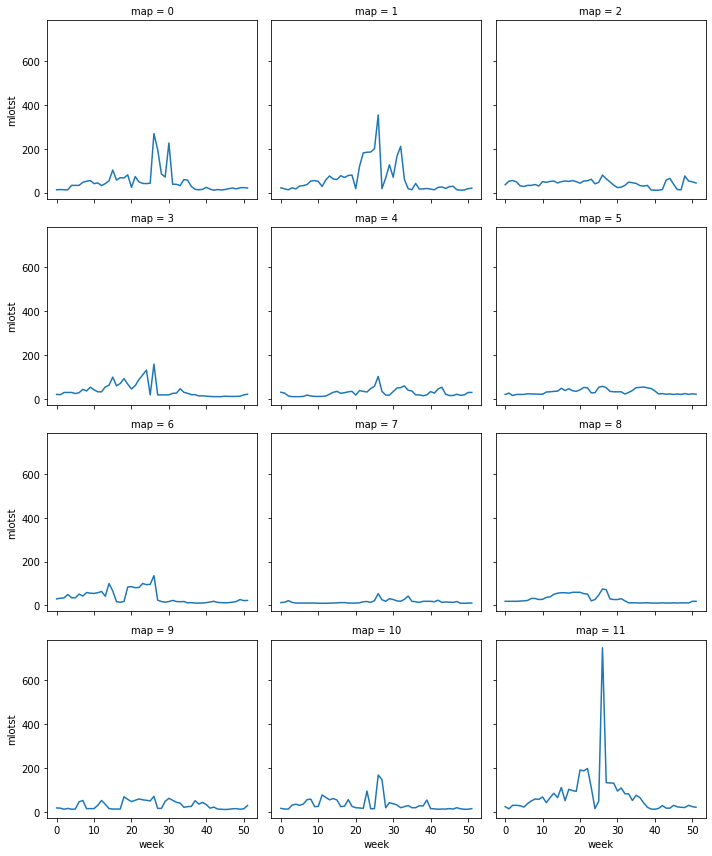

In [140]:
shifted[:,1200:1380:15].T.plot(col="map", col_wrap=3, hue='map')

In [45]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca_s = PCA(n_components=n_components)
pca_s.fit(shifted.T)

PCA(n_components=12)

In [46]:
print(pca_s.singular_values_)

[59597.5455522  24144.08732436 17268.05261818 14672.72223629
 13984.76109314 12055.33522886 11456.77643538 10391.20958704
 10227.38577471  9655.43158396  9155.37075506  8756.00825049]


In [48]:
## 53x12
reduced_values_s = pca_s.transform(shifted.T)

In [49]:
reduced_values_s.shape

(40801, 12)

In [50]:
## 53x12
print(pca_s.components_.size)

624


In [51]:
samp = reduced_values_s.shape[0]
eof = reduced_values_s.shape[1]
w = shifted.week.size

data = np.zeros((samp,eof,w))

result_s = xr.DataArray(data, dims=['sample', 'n_eof', 'week'], name="fake_data")

In [53]:
result_s['reduced_data'] = xr.DataArray(reduced_values_s, dims=['sample', 'n_eof'])

result_s['eigen_values'] = xr.DataArray(pca_s.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result_s['explained_variance'] = xr.DataArray(pca_s.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

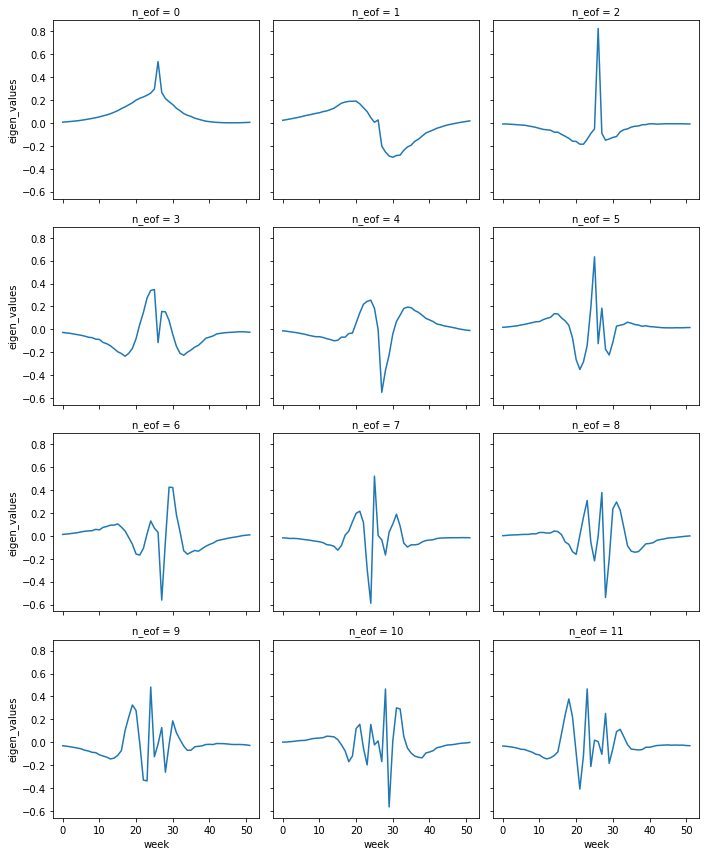

In [148]:
result_s['eigen_values'].plot(col="n_eof", col_wrap=3, hue='n_eof')
plt.show()

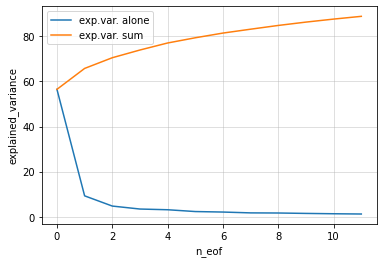

In [61]:
result_s['explained_variance'].plot(label='exp.var. alone')
result_s['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [127]:
PC_s = result_s['eigen_values'].dot(shifted.T, dims='week')

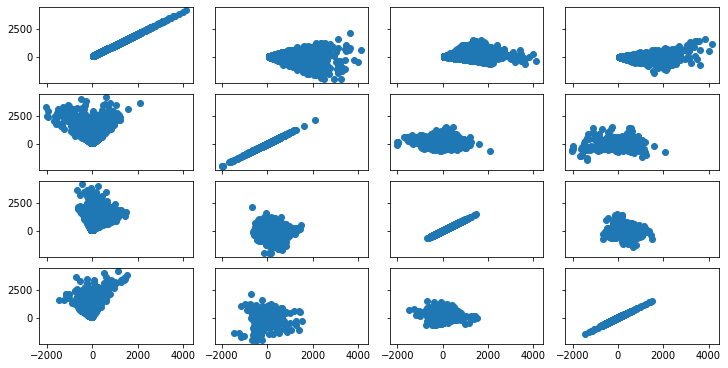

In [64]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5), 
                       sharex=True, sharey=True, constrained_layout=True)
for i in range(4):
    for j in range(4):
        x = PC_s[i]
        y = PC_s[j]
        name = 'PC' + str(i) + '-' + str(j)

        ax[i,j].scatter(x, y)
        #ax[i,j].set_ylabel(name)

plt.show()

## PCA for normalized-un-shifted dataset

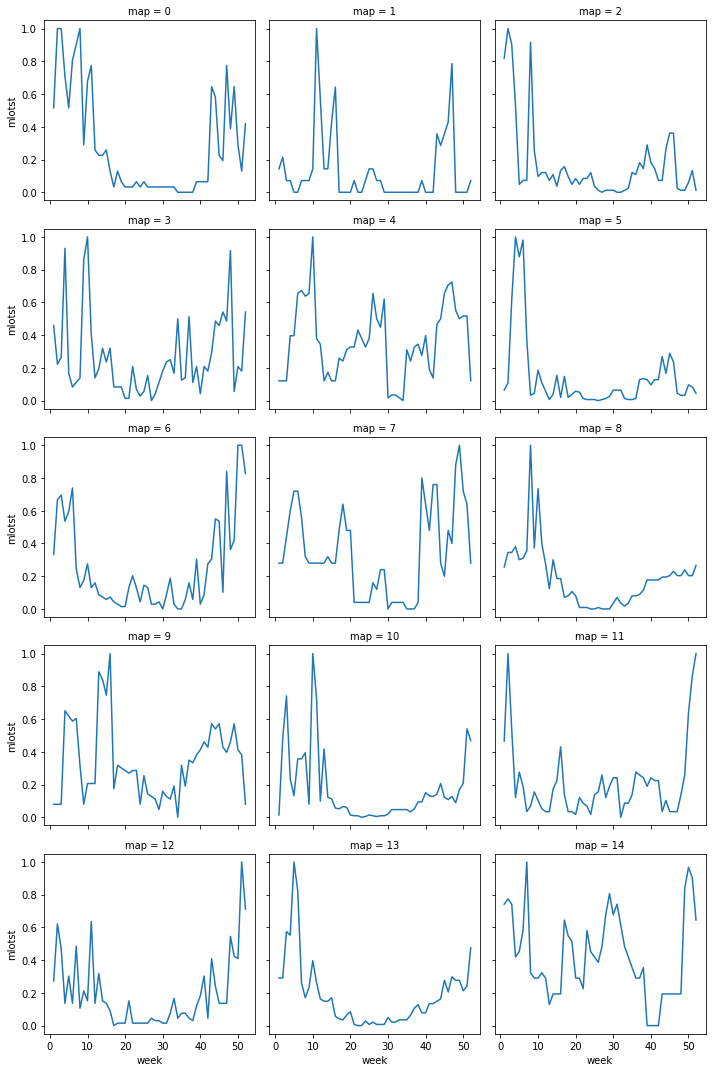

In [134]:
normalized_o[:,100:320:15].T.plot(col="map", col_wrap=3, hue='map')

In [65]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca_no = PCA(n_components=n_components)
pca_no.fit(normalized_o.T)

PCA(n_components=12)

In [66]:
print(pca_no.singular_values_)

[128.35576537 109.60694189 101.22402217  81.58968141  70.752736
  66.42278294  55.6425539   53.55329768  51.66922152  47.1881399
  45.09825816  42.70819859]


In [67]:
## 53x12
reduced_values_no = pca_no.transform(normalized_o.T)

In [69]:
reduced_values_no.shape

(40799, 12)

In [70]:
## 53x12
print(pca_no.components_.size)

624


In [71]:
samp = reduced_values_no.shape[0]
eof = reduced_values_no.shape[1]
w = normalized_o.week.size

data = np.zeros((samp,eof,w))

result_no = xr.DataArray(data, dims=['sample', 'n_eof', 'week'], name="fake_data")

In [72]:
result_no['reduced_data'] = xr.DataArray(reduced_values_no, dims=['sample', 'n_eof'])

result_no['eigen_values'] = xr.DataArray(pca_no.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result_no['explained_variance'] = xr.DataArray(pca_no.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

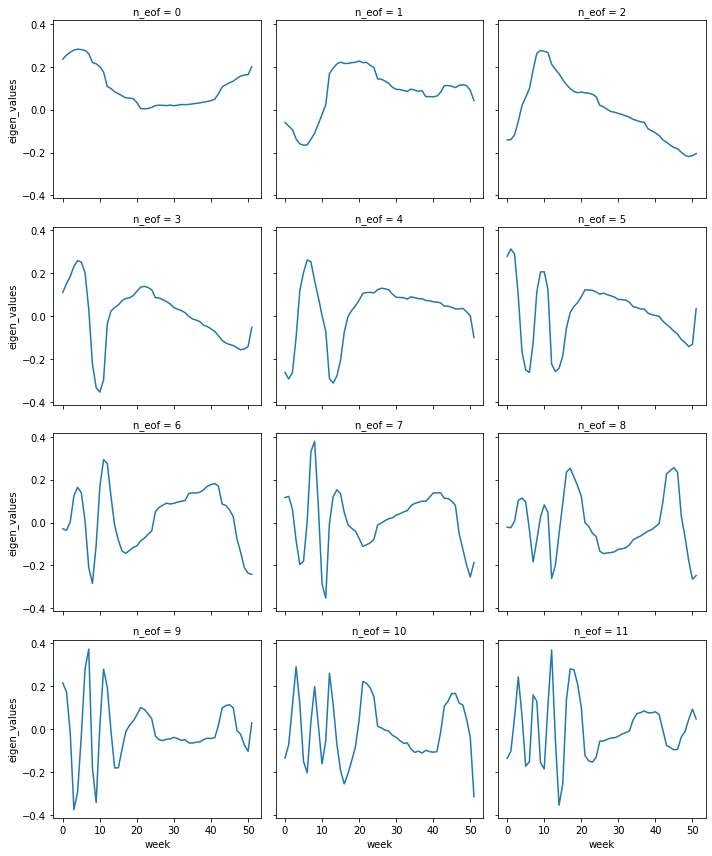

In [150]:
result_no['eigen_values'].plot(col="n_eof", col_wrap=3, hue='n_eof')
plt.show()

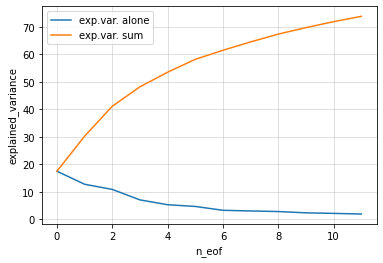

In [81]:
result_no['explained_variance'].plot(label='exp.var. alone')
result_no['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [129]:
PC_no = result_no['eigen_values'].dot(normalized_o.T, dims='week')


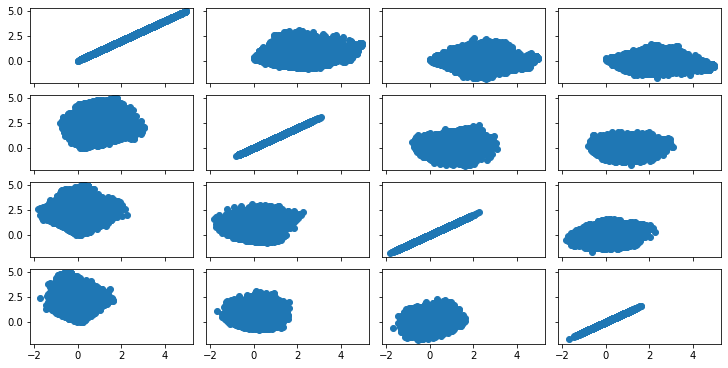

In [83]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5), 
                       sharex=True, sharey=True, constrained_layout=True)
for i in range(4):
    for j in range(4):
        x = PC_no[i]
        y = PC_no[j]
        name = 'PC' + str(i) + '-' + str(j)

        ax[i,j].scatter(x, y)

plt.show()

## PCA for normalized-shifted dataset

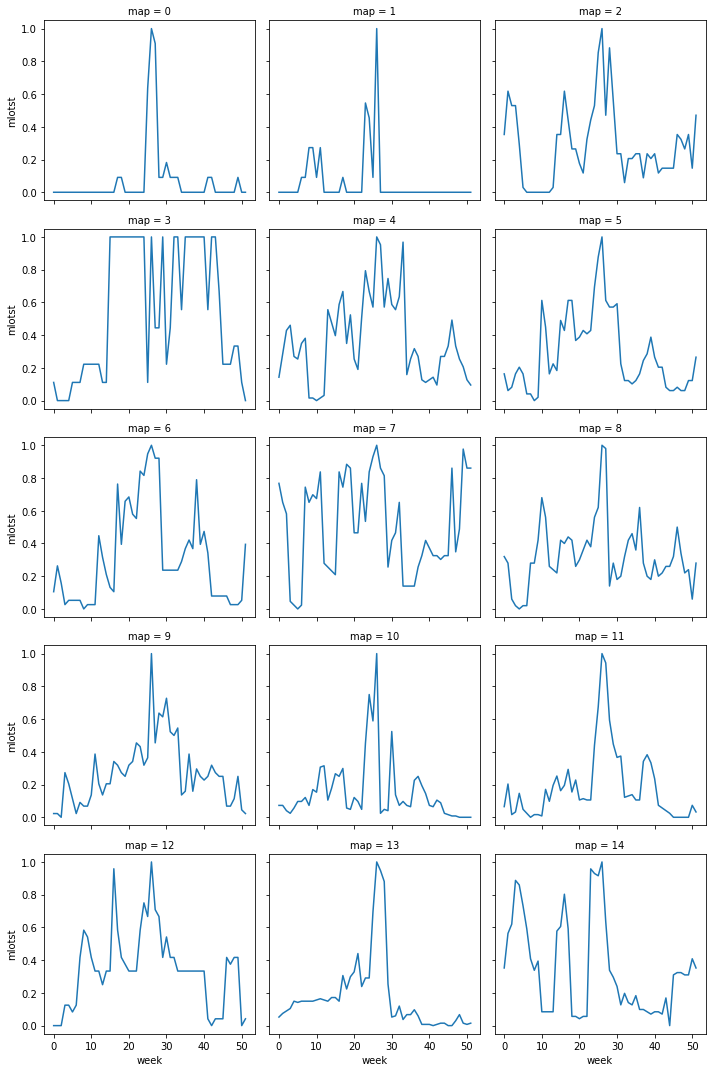

In [119]:
normalized_s[:,0:220:15].T.plot(col="map", col_wrap=3, hue='map')

In [89]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca_ns = PCA(n_components=n_components)
pca_ns.fit(normalized_s.T)

PCA(n_components=12)

In [90]:
print(pca_ns.singular_values_)

[132.96197481 122.3729853   94.62092391  70.8263195   64.78922518
  56.4692477   51.56342218  47.79073642  45.59202626  43.08216356
  41.31407725  38.19023953]


In [91]:
## 53x12
reduced_values_ns = pca_ns.transform(normalized_o.T)

In [92]:
reduced_values_ns.shape

(40799, 12)

In [93]:
## 53x12
print(pca_ns.components_.size)

624


In [95]:
samp = reduced_values_ns.shape[0]
eof = reduced_values_ns.shape[1]
w = normalized_o.week.size

data = np.zeros((samp,eof,w))

result_ns = xr.DataArray(data, dims=['sample', 'n_eof', 'week'], name="fake_data")

In [98]:
result_ns['reduced_data'] = xr.DataArray(reduced_values_ns, dims=['sample', 'n_eof'])

result_ns['eigen_values'] = xr.DataArray(pca_ns.components_, dims=['n_eof', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result_ns['explained_variance'] = xr.DataArray(pca_ns.explained_variance_ratio_*100, 
                                        dims=['n_eof'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

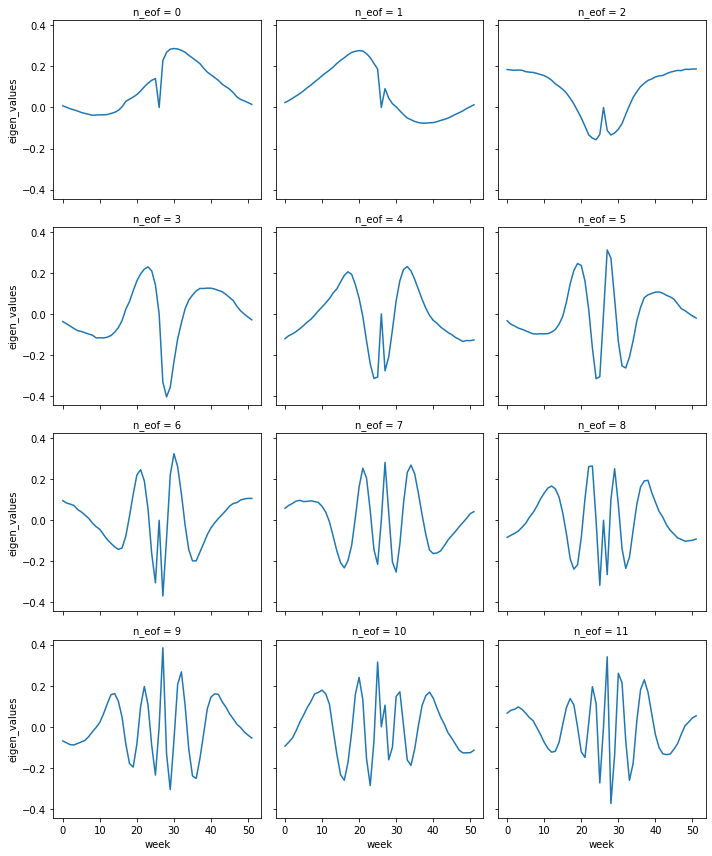

In [151]:
result_ns['eigen_values'].plot(col="n_eof", col_wrap=3, hue='n_eof')
plt.show()

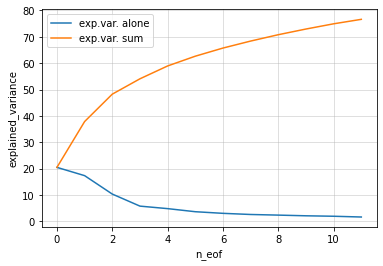

In [106]:
result_ns['explained_variance'].plot(label='exp.var. alone')
result_ns['explained_variance'].cumsum(dim='n_eof').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [131]:
PC_ns = result_ns['eigen_values'].dot(normalized_s.T, dims='week')

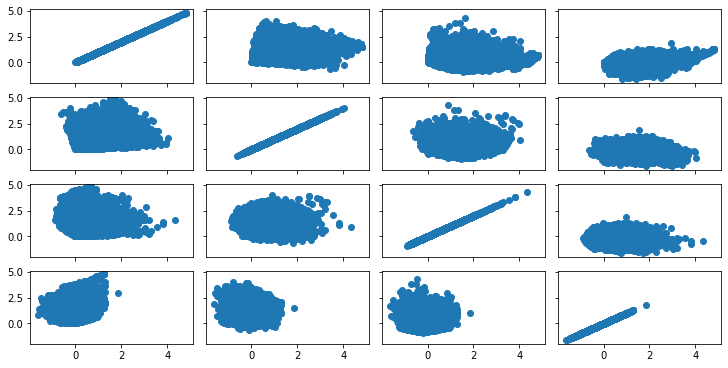

In [132]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,5), 
                       sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        x = PC_ns[i]
        y = PC_ns[j]
        name = 'PC' + str(i) + '-' + str(j)

        ax[i,j].scatter(x, y)
        ax[i,j].set_label(name)

plt.show()